In [1]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [2]:
HOME = "/Users/andrewbailey/CLionProjects/rrna_analysis" 
figures = os.path.join(HOME, "figures/control_experiment")
rh = ReferenceHandler("/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa")

IVT_vs_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_Nop58_GAL.level_compare_sample.tombo.stats")


In [3]:
rrna_ref_name = "RDN18-1"
stats_files = [IVT_vs_Nop58_GAL]
min_dstat = 0.9
gap = 5
n_positions = {"RDN18-1": 36, 
               "RDN25-1": 73}


In [12]:
def plot_and_get_random_canonical_pos(rrna_ref_name, stats_files, min_dstat=0.9, gap=5, random=False, figure_path=None, positions=None, n_positions={"RDN18-1": 36, "RDN25-1": 73}):
    
    title = f"Histogram of per-position D-statistics: {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("D-statistic")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.set_ylim(0, 1)
    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    panel1.set_title(label=title)

    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        ts = tombo_stats.TomboStats(stats_files[i])
        for contig in ts:
            if contig[0] == rrna_ref_name and contig[1] == "+":
                all_data = contig[4]
                panel1.plot([x[1] for x in all_data], [1-x[0] for x in all_data], label="Dstatistic")
                ok_positions = []
                skip = True
                counter = 0
                for x in all_data:
                    if x[0] >= min_dstat:
                        if skip and counter <= gap:
                            counter += 1
                            continue
                #         print("append")
                        ok_positions.append([x[1], 1-x[0]])
                        skip = False
                        counter = 0
                    else:
                        if not skip:
                            for i in range(gap):
                                if ok_positions:
                                    ok_positions.pop()
                        skip = True

    for i, (pos, level) in enumerate(ok_positions):
        if i == 0:
            line1, = panel1.plot(pos, level, color='r', linewidth=0, marker='o', ms=5, label=f"Canonical Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, level, color='r', marker='o')

    ok_positions = pd.DataFrame(ok_positions)
    
    if random and positions is not None:
        positions = np.random.choice(len(ok_positions), n_positions[rrna_ref_name], replace=False)
        selected_positions = pd.DataFrame(ok_positions).iloc[positions]
    else:
        selected_positions = ok_positions[ok_positions[0].isin(positions)]


    for i, (index, row) in enumerate(selected_positions.iterrows()):
        pos = row[0]
        level = row[1]

        if i == 0:
            line2, = panel1.plot(pos, level, color='g', linewidth=0, marker='o', ms=5, label=f"Random Canonical Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, level, color='g', marker='o')
    
    panel1.legend()        
    if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
        plt.savefig(figure_path)
    else:
        plt.show()

    return selected_positions.sort_values(by=[0])


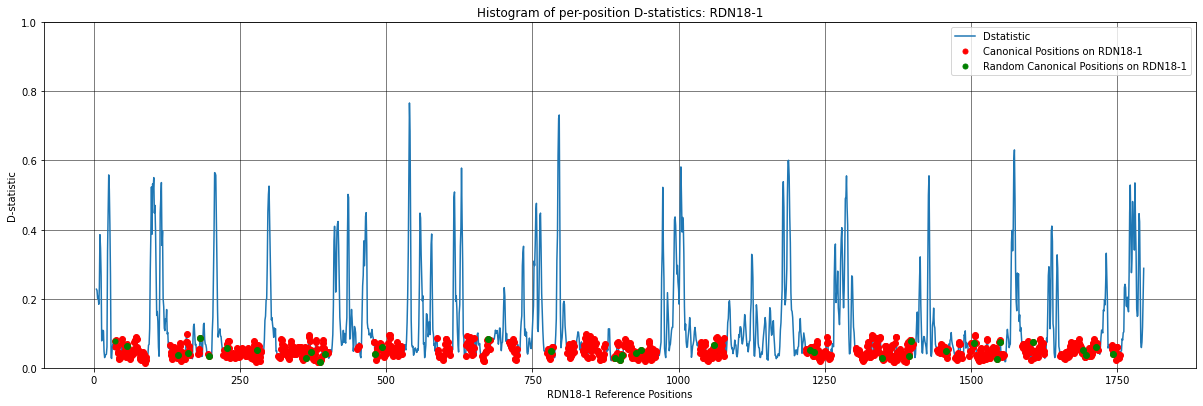

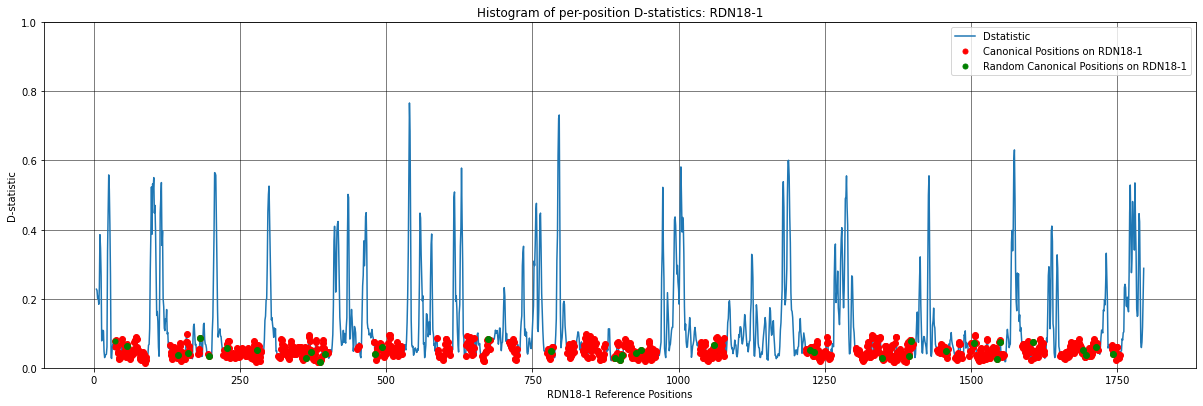

In [13]:
prev_random = [37, 57, 145, 161, 182, 197, 228, 280, 363, 371, 387, 396, 481, 493, 674, 782, 892, 900, 903, 928, 936, 1060, 1225, 1232, 1348, 1394, 1398, 1457, 1505, 1545, 1550, 1605, 1691, 1696, 1713, 1743]
figure_path = os.path.join(figures, "hist_18S_canonical.png")
selected_positions_18 = plot_and_get_random_canonical_pos("RDN18-1", stats_files, positions=prev_random, figure_path=figure_path)
figure_path = os.path.join(figures, "hist_18S_canonical.svg")
selected_positions_18 = plot_and_get_random_canonical_pos("RDN18-1", stats_files, positions=prev_random, figure_path=figure_path)


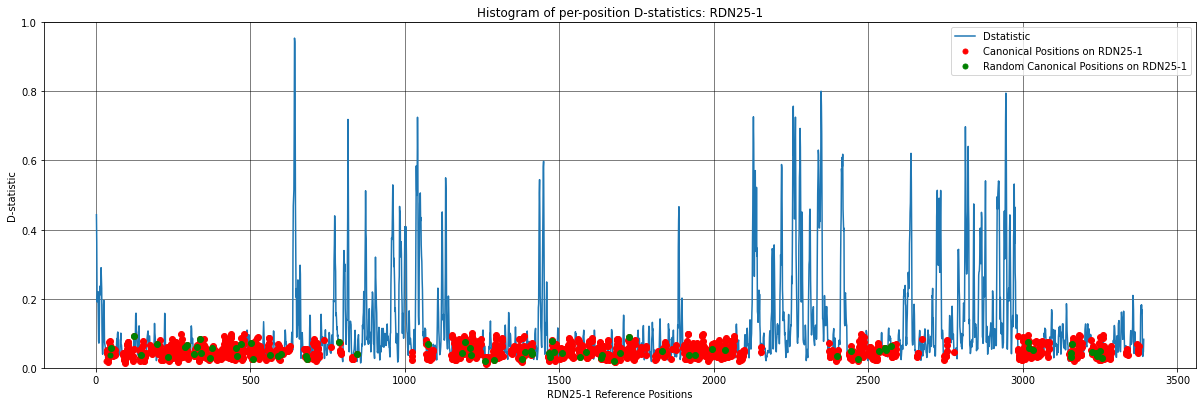

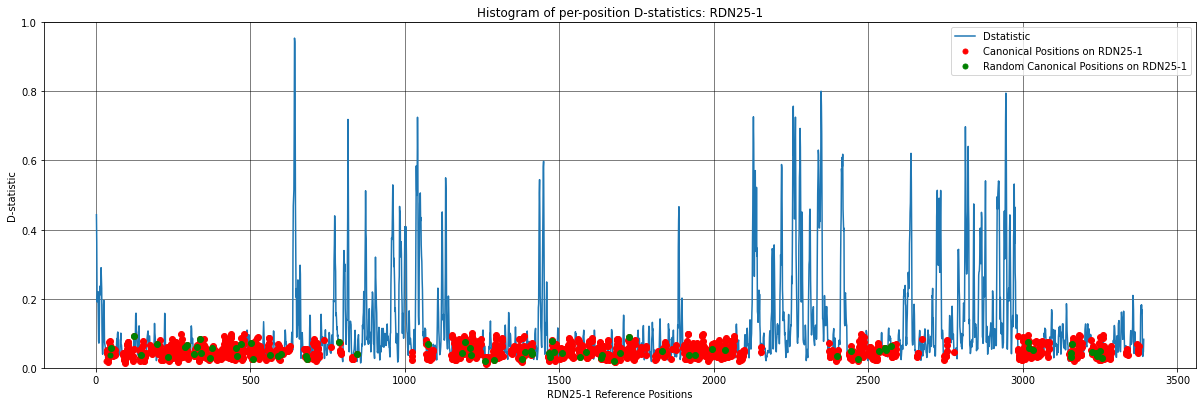

In [14]:
prev_random = [47, 49, 123, 146, 199, 234, 287, 294, 318, 328, 338, 341, 369, 377, 455, 458, 470, 501, 510, 564, 590, 600, 679, 684, 788, 846, 1075, 1184, 1195, 1210, 1213, 1261, 1287, 1380, 1389, 1408, 1412, 1413, 1468, 1471, 1475, 1483, 1508, 1568, 1587, 1636, 1638, 1678, 1696, 1724, 1833, 1918, 1938, 1993, 2036, 2400, 2443, 2465, 2533, 2553, 2557, 2573, 3016, 3021, 3032, 3156, 3157, 3158, 3223, 3235, 3241, 3250, 3257]
figure_path = os.path.join(figures, "hist_25S_canonical.png")
selected_positions_25 = plot_and_get_random_canonical_pos("RDN25-1", stats_files, positions=prev_random, figure_path=figure_path)
figure_path = os.path.join(figures, "hist_25S_canonical.svg")
selected_positions_25 = plot_and_get_random_canonical_pos("RDN25-1", stats_files, positions=prev_random, figure_path=figure_path)


In [7]:
replace_bases = {"A": 'afj',
                 "T": 'dghlm',
                 "G": 'ck',
                 "C": 'bei'}




canonical_bases = {"A": 'n',
                   "T": 'q',
                   "C": 'o',
                   "G": 'p'}

c_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_canonical.positions")
m_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_modified.positions")
v_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_variants.positions")



with open(c_positions, 'w') as c, open(m_positions, 'w') as m, open(v_positions, 'w') as v:
    for index, row in selected_positions_18.iterrows():
        pos = row[0]
        level = row[1]
        ref_base = rh.get_sequence("RDN18-1", pos, pos+1)
        rep_base = np.random.choice(list(replace_bases[ref_base]), 1)[0]
        c_base = canonical_bases[ref_base]
        variant = c_base+rep_base

#         print("\t".join(["RDN18-1", str(int(pos)), "+", ref_base, rep_base]), file=m)
#         print("\t".join(["RDN18-1", str(int(pos)), "+", ref_base, variant]), file=v)
#         print("\t".join(["RDN18-1", str(int(pos)), "+", ref_base, c_base]), file=c)

        
    for index, row in selected_positions_25.iterrows():
        pos = row[0]
        level = row[1]
        ref_base = rh.get_sequence("RDN25-1", pos, pos+1)
        rep_base = np.random.choice(list(replace_bases[ref_base]), 1)[0]
        c_base = canonical_bases[ref_base]
        variant = c_base+rep_base

#         print("\t".join(["RDN25-1", str(int(pos)), "+", ref_base, rep_base]), file=m)
#         print("\t".join(["RDN25-1", str(int(pos)), "+", ref_base, variant]), file=v)
#         print("\t".join(["RDN25-1", str(int(pos)), "+", ref_base, c_base]), file=c)

        

# Fake Mod File

In [13]:
pos_file = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/control_position_files/control_18S_25S_variants_canonical.positions"
out_file = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/control_position_files/mod_file.csv"
with open(pos_file, 'r') as fh, open(out_file, 'w') as outfh:
    print("contig,mod,pos,percent,strand", file=outfh)
    for x in fh:
        row = x.split()
#         print(row)
#         RDN25-1,Pseudouridine,2865,95,+
        print(",".join([row[0], "Canonical", str(int(row[1])+1), "100", "+"]), file=outfh)

### Plot control experiment

In [8]:
import os
import numpy as np
from py3helpers.aws import AwsS3
from rrna_analysis.plot_experiment_table import plot_acc_heatmap_for_experiment
from rrna_analysis.multiple_model_accuracy import plot_accuracy_vs_delta_and_accuracy_over_time, preprocess_accuracy_csv
from rrna_analysis.kmer_pos_mapping import KmerPosMapping
import pandas as pd

mods_csv = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/control_position_files/mod_file.csv"
reference = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa"
positions = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/control_position_files/control_18S_25S_variants.positions"
kpm = KmerPosMapping(reference, positions, mods_csv)
client = AwsS3()


Enter MFA code for arn:aws:iam::652235167018:mfa/andbaile@ucsc.edu: ········


In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [10]:
model_n = 30
# key="accuracy"
# key="recall"
# key="specificity"
# key="precision"
# key="negative_predictive_value"
# key="recall"
# key="f1_score"
# key="brier_score"
# key="auroc"

max_percent=100
min_percent=0
min_delta=0
max_delta=np.inf

_control="/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/control/alt_canonical/train_500_test_500_prob_0.5_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_alt_c_6mer"  



In [11]:
key="accuracy"
high_percent=100
low_percent=0
low_delta=0
high_delta=np.inf
max_delta=False
aot=True
avd=True
model_n = 30


<IPython.core.display.Javascript object>


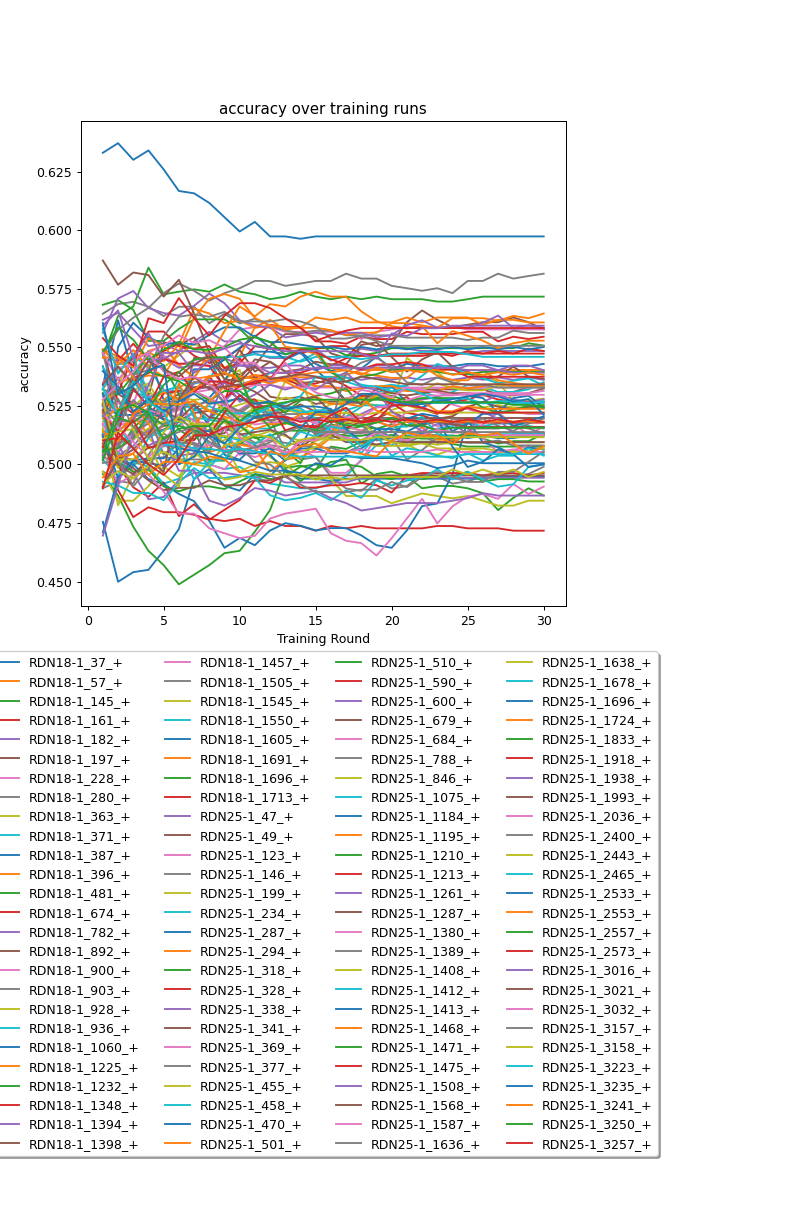

<IPython.core.display.Javascript object>


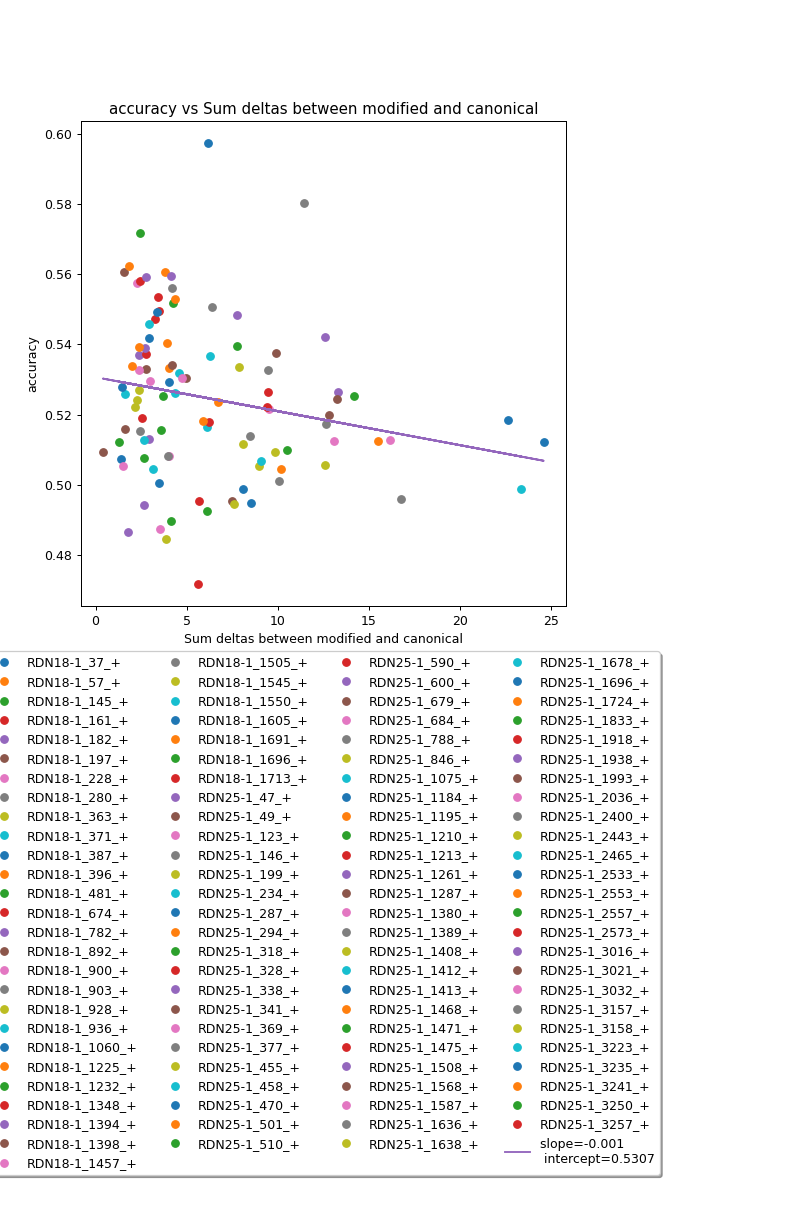

In [12]:
%matplotlib notebook
experiment_path = _control

dir_path = os.path.join(experiment_path, "testing_accuracy_csvs")
model_dir = os.path.join(experiment_path, "training_models")
p, k = plot_accuracy_vs_delta_and_accuracy_over_time(kpm,
                                                     dir_path, 
                                                     model_dir, 
                                                         model_n, 
                                                         high_percent=high_percent, 
                                                         low_percent=low_percent, 
                                                         low_delta=low_delta, 
                                                         high_delta=high_delta, 
                                                         key=key, 
                                                         max_delta=max_delta,
                                                         aot=aot,
                                                         avd=avd)  
